# Plot bet-1::mSG upon COH-1 cleavage

In [7]:
#import napari
#import torch
#from skimage.measure import regionprops_table, regionprops
#import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
#import gc
import seaborn as sns
#from sklearn.mixture import GaussianMixture
from bioio import BioImage
#import bioio_nd2
#import bioio_tifffile
#from bioio.writers import OmeTiffWriter
from scipy import optimize
from scipy.stats import mannwhitneyu
#import json
#import re
from convert_paths import correct_path, correct_save_path, correct_loaded_path



pd.set_option('display.max_columns', None)

## Input settings

In [8]:
nucChannel = 0 # red emerin rings
spotChannel = 0 # green spots
path_type='mac'


#base_path = correct_path('/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Kalyan', path_type)
base_path = correct_path('/mnt/external.data/MeisterLab/jsemple/demo_VIBE/results', path_type)

#df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-25-02_bet1-mSG_wPM1353')]})
#df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-04-03_bet1-mSG_wPM1353')]})
#df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-10-05_bet1-mSG_wPM1353')]})
df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-10-05_bet1-mSG_wPM1353')]})


output_path=os.path.join(base_path,"plots")

if not os.path.exists(output_path):
    os.makedirs(output_path)

# to choose between different ways of processing the data. individual image files will 
# get overwritten, but collected tables with have this specific suffix.
versionSuffix = 'v001'
filterNuclei = False

df=pd.DataFrame()
dist=pd.DataFrame()
file_list = pd.DataFrame()
for df_path in df_paths['data_path']:
    df_tmp=pd.read_csv(os.path.join(df_path,"nuclei_analysis_"+versionSuffix+".csv"))
    df = pd.concat([df,df_tmp])
    dist_tmp=pd.read_pickle(os.path.join(df_path,"dist_analysis_"+versionSuffix+".pkl"))
    dist = pd.concat([dist,dist_tmp])
    file_list_tmp = pd.read_csv(os.path.join(df_path,"fileList_wormMasks.csv"))
    file_list = pd.concat([file_list,file_list_tmp])



df.reset_index(drop=True,inplace=True)
dist.reset_index(drop=True,inplace=True)
file_list.reset_index(drop=True,inplace=True)
correct_loaded_path(df, path_type, col_names=['raw_filepath', 'denoised_filepath'])
correct_loaded_path(dist, path_type, col_names=['raw_filepath', 'denoised_filepath'])
correct_loaded_path(file_list, path_type, col_names=['raw_filepath', 'denoised_filepath'])
df.head()


,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_regions_all,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,worm_region,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,anisotropy,pixelSize,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber
0,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,4,0,1165,1516,18,1226,1592,50830.0,8.269703,1195.146292,1554.833976,79.423564,0.944164,head,18,61,76,298.026264,285.0,72.125986,15148675,5202.157819,776,142,50830,191.297566,26.368439,6239744,32618,0,3.0,0.065,4.501576,0.101966,0.005103,126.827283,1.601252,0.115017,0.023541,126.308164
1,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,7,0,1242,1453,11,1287,1493,13317.0,4.737478,1263.519862,1472.512202,46.930152,0.956544,head,11,45,40,269.780281,262.0,53.416394,3592664,2853.311189,539,158,13317,198.251273,18.632973,1285263,6483,0,3.0,0.065,3.467476,0.123307,0.010198,33.257161,1.286456,0.060496,0.008451,1827.224019
2,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,8,0,1255,1344,10,1315,1413,25590.0,4.039625,1284.751504,1376.015709,75.379585,0.952931,head,10,60,69,292.216256,291.0,41.005185,7477814,1681.425214,492,166,25590,240.166730,54.320065,3797036,15810,0,3.0,0.065,3.294682,0.199134,0.019951,27.629323,3.164170,0.283249,0.029170,24.026838
3,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,9,0,1262,1491,12,1299,1537,13661.0,5.514896,1280.125540,1513.195300,49.023365,0.952185,head,12,37,46,286.522509,275.0,64.006227,3914184,4096.797037,532,150,13661,196.065060,27.467705,1325988,6763,0,3.0,0.065,4.179687,0.161282,0.009151,80.737632,1.300267,0.045974,0.006825,1441.559573
4,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,10,0,1300,1375,24,1341,1438,21553.0,11.602515,1318.360367,1405.693778,71.422551,0.766356,head,24,41,63,312.100172,306.0,58.275612,6726695,3396.046988,623,184,21553,222.323648,65.902842,8990546,40439,0,3.0,0.065,3.705435,0.147821,0.011767,45.820907,4.748582,0.328237,0.015899,193.041054


In [6]:
dist.head()

,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_regions_all,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,image,intensity_image,worm_region,intensity_background,mask_background,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,intensity_dist_spots,intensity_dist,zproj_spots,zproj_background,anisotropy,pixelSize,spot_ACF,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,spot_ac_fittedParams,spot_ac_fittedParams_err,bg_ACF,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,bg_ac_fittedParams,bg_ac_fittedParams_err
0,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,4,0,1165,1516,18,1226,1592,50830.0,8.269703,1195.146292,1554.833976,79.423564,0.944164,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",head,"[[[225, 170, 179, 153, 189, 144, 184, 184, 168...","[[[True, True, True, True, True, True, True, T...",18,61,76,298.026264,285.0,72.125986,15148675,5202.157819,776,142,50830,191.297566,26.368439,6239744,32618,0,"[232.5673469387755, 272.7951807228916, 309.680...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[248, 185, 211, 199, 189, 200, 203, 226, 217,...",3.0,0.065,"[1.0, 0.8196593151248551, 0.700533727985255, 0...",4.501576,0.101966,0.005103,126.827283,"[0.09002582682602242, 0.9041750253440618, 0.19...","[0.007850468812025209, 0.007258974001274672, 0...","[1.0, 0.2916357695770118, 0.1643055046153783, ...",1.601252,0.115017,0.023541,126.308164,"[0.027931071425845118, 0.9646880301389313, 1.1...","[0.008871244659035124, 0.027875912255745115, 0..."
1,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,7,0,1242,1453,11,1287,1493,13317.0,4.737478,1263.519862,1472.512202,46.930152,0.956544,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",head,"[[[188, 168, 164, 178, 224, 160, 169, 189, 172...","[[[True, True, True, True, True, True, True, T...",11,45,40,269.780281,262.0,53.416394,3592664,2853.311189,539,158,13317,198.251273,18.632973,1285263,6483,0,"[223.6291390728477, 249.01324503311258, 271.49...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[198, 209, 193, 194, 224, 205, 219, 214, 193,...",3.0,0.065,"[1.0, 0.7479774834079461, 0.6003281971202218, ...",3.467476,0.123307,0.010198,33.257161,"[0.10814286308940427, 0.8754947722940903, 0.28...","[0.009235951769104347, 0.011244923674356958, 0...","[1.0, 0.0909553422231381, 0.04083644224441243,...",1.286456,0.060496,0.008451,1827.224019,"[0.0074712684703194775, 0.9923127115559347, 2....","[0.002958102432074247, 0.010071920360842094, 0..."
2,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,8,0,1255,1344,10,1315,1413,25590.0,4.039625,1284.751504,1376.015709,75.379585,0.952931,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",head,"[[[198, 206, 168, 194, 201, 184, 202, 192, 202...","[[[True, True, True, True, True, True, True, T...",10,60,69,292.216256,291.0,41.005185,7477814,1681.425214,492,166,25590,240.166730,54.320065,3797036,15810,0,"[245.87394957983193, 268.1308016877637, 286.55...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[

## Add some variables
Radius might scale more linearly than volume
Coefficient of variation is independent of the mean signal

In [9]:
def coefficientOfVariation(std,mean):
    return std/mean

df['cv'] = coefficientOfVariation(df['std'],df['mean'])

df.rename(columns={'worm_region_x':'worm_regions_all','worm_region_y':'worm_region'},inplace=True)
dist.rename(columns={'worm_region_x':'worm_regions_all','worm_region_y':'worm_region'},inplace=True)

df.head()


,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_regions_all,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,worm_region,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,anisotropy,pixelSize,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,cv
0,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,4,0,1165,1516,18,1226,1592,50830.0,8.269703,1195.146292,1554.833976,79.423564,0.944164,head,18,61,76,298.026264,285.0,72.125986,15148675,5202.157819,776,142,50830,191.297566,26.368439,6239744,32618,0,3.0,0.065,4.501576,0.101966,0.005103,126.827283,1.601252,0.115017,0.023541,126.308164,0.242012
1,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,7,0,1242,1453,11,1287,1493,13317.0,4.737478,1263.519862,1472.512202,46.930152,0.956544,head,11,45,40,269.780281,262.0,53.416394,3592664,2853.311189,539,158,13317,198.251273,18.632973,1285263,6483,0,3.0,0.065,3.467476,0.123307,0.010198,33.257161,1.286456,0.060496,0.008451,1827.224019,0.198000
2,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,8,0,1255,1344,10,1315,1413,25590.0,4.039625,1284.751504,1376.015709,75.379585,0.952931,head,10,60,69,292.216256,291.0,41.005185,7477814,1681.425214,492,166,25590,240.166730,54.320065,3797036,15810,0,3.0,0.065,3.294682,0.199134,0.019951,27.629323,3.164170,0.283249,0.029170,24.026838,0.140325
3,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,9,0,1262,1491,12,1299,1537,13661.0,5.514896,1280.125540,1513.195300,49.023365,0.952185,head,12,37,46,286.522509,275.0,64.006227,3914184,4096.797037,532,150,13661,196.065060,27.467705,1325988,6763,0,3.0,0.065,4.179687,0.161282,0.009151,80.737632,1.300267,0.045974,0.006825,1441.559573,0.223390
4,2025_10_05_wPM1353_HS_001,2025-10-05,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-10-05_2025_10_05_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,/mnt/izbkingston/MeisterLab/jsemple/demo_VIBE/...,head;body_other,10,0,1300,1375,24,1341,1438,21553.0,11.602515,1318.360367,1405.693778,71.422551,0.766356,head,24,41,63,312.100172,306.0,58.275612,6726695,3396.046988,623,184,21553,222.323648,65.902842,8990546,40439,0,3.0,0.065,3.705435,0.147821,0.011767,45.820907,4.748582,0.328237,0.015899,193.041054,0.186721


## Number of nuclei per worm/worm_region

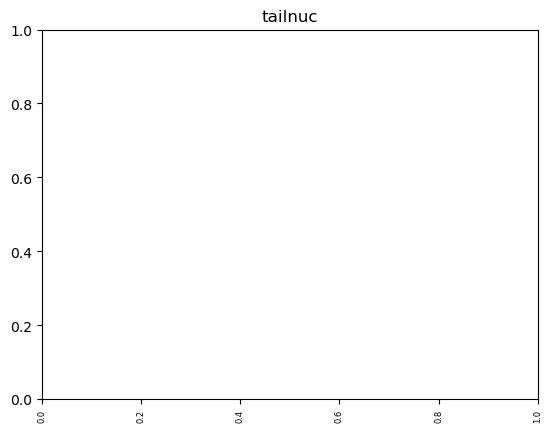

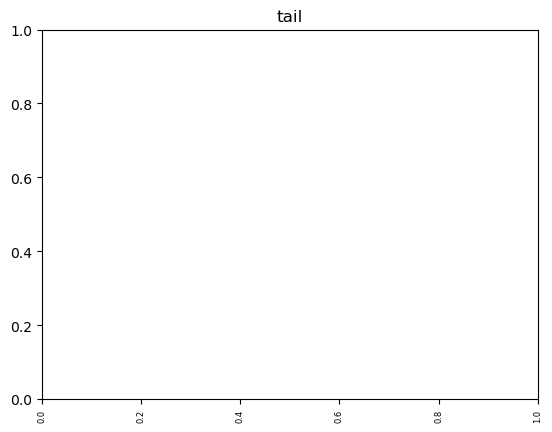

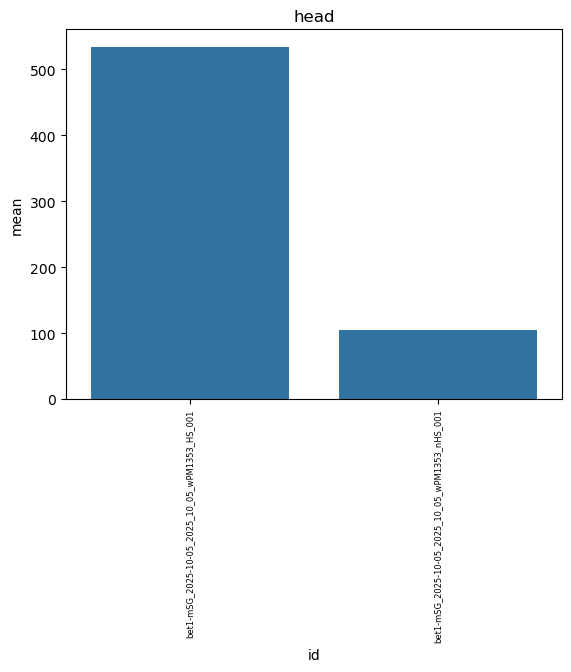

In [10]:
df_subset = df[(df['worm_region'] == "tailnuc")]
nucCounts=df_subset[df_subset.worm_region=="tailnuc"].groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)
plt.title("tailnuc")
plt.show()

df_subset = df[(df['worm_region'] == "tail")]
nucCounts=df_subset[df_subset.worm_region=="tail"].groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)
plt.title("tail")
plt.show()

df_subset = df[(df['worm_region'] == "head")]
nucCounts=df_subset[df_subset.worm_region=="head"].groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)
plt.title("head")
plt.show()


indeces_to_exclude = [18]

## Functions for plotting table metrics

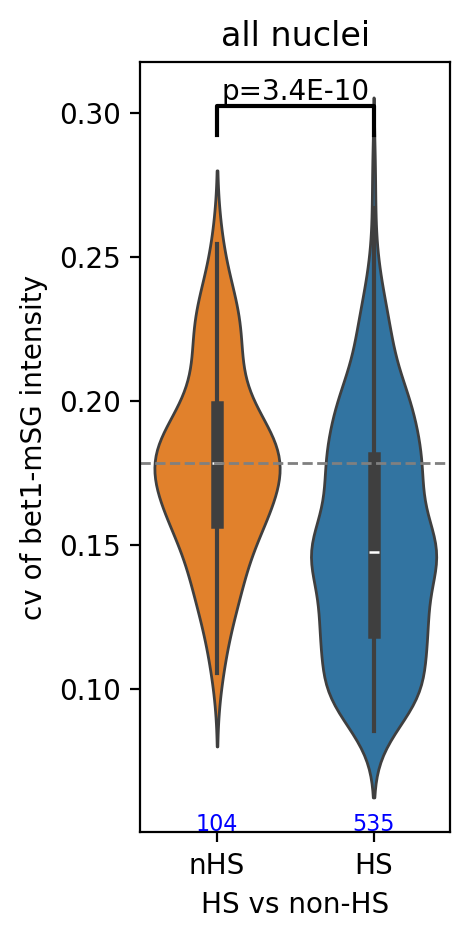

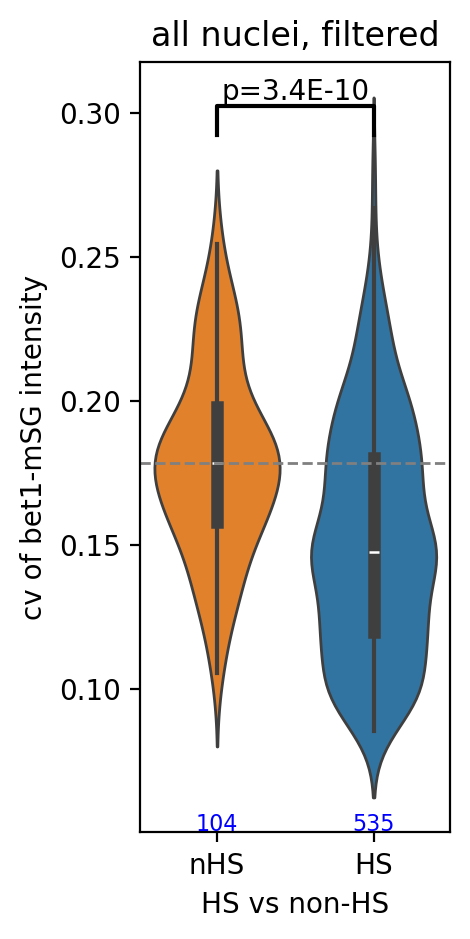

In [11]:
def format_p_value(pvalue):
    if pvalue < 0.001:
        return "{:.1E}".format(pvalue)
    else:
        return f"{pvalue:.3f}"


def plot_violin(df,file_list,output_path, metric='cv',title=''):
    p = df.protein.unique()[0]
    plt.figure(figsize = (2,5),dpi = 200)
    order= ['nHS', 'HS']
    ax=sns.violinplot(data=df, y=metric, x="treatment",hue="treatment", order=order, linewidth=1)
    
    res = mannwhitneyu(x=df[metric][df['treatment'] == "HS"], y=df[metric][df['treatment'] == "nHS"])
    # statistical annotation
    x1, x2 = 0, 1   
    y, h, col = df[metric].max() + 0.01, 0.01, 'k'

    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "p="+format_p_value(res.pvalue), ha='center', va='bottom', color=col)

    plt.xlabel("HS vs non-HS")
    plt.ylabel(metric+" of "+p+" intensity")
    plt.title(title)

    # add horizontal line for t=0
    nHS_median = df[df['treatment'] == "nHS"][metric].median()
    plt.axhline(y=nHS_median, color='grey', linestyle='--', linewidth=1)

   # get number of nuclei at each timepoint
    num_nuclei = df.groupby(['treatment'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]+0.01*np.abs(ylims[0])
    for n in range(len(num_nuclei)):
        plt.text(x=num_nuclei.treatment.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')

    #plt.savefig(os.path.join(output_path,"plot_"+metric+"_"+str(np.where(filterNuclei, "filtNuclei", "allNuclei"))+".png"))
    plt.show()

df_subset = df[(df['worm_region'] != 'tailnuc')]
plot_violin(df_subset,file_list,output_path, metric='cv',title='all nuclei')


df_subset = df[(df['solidity'] != np.inf) & (df['worm_region'] != 'tailnuc')]
plot_violin(df_subset,file_list,output_path, metric='cv',title='all nuclei, filtered')

In [18]:
if(df['worm_region'].unique() == "tailnuc").any():
    df_subset = df[(df['worm_region'] == "tailnuc")]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='tail tip')

    df_subset = df[(df['worm_region'] == "tailnuc") & (df['solidity'] != np.inf) ]
    plot_violin(df_subset,file_list,output_path, metric='cv',title='tail tip, filtered')

In [19]:
if(df['worm_region'].unique() == "tail").any():
    df_subset = df[(df['worm_region'] == "tail")]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='tail all')

    df_subset = df[(df['worm_region'] == "tail") & (df['solidity'] != np.inf) ]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='tail all, filtered ')

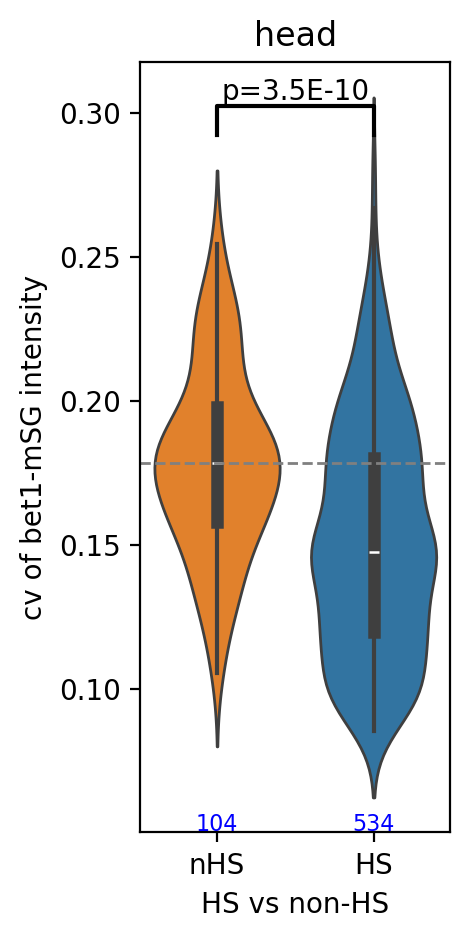

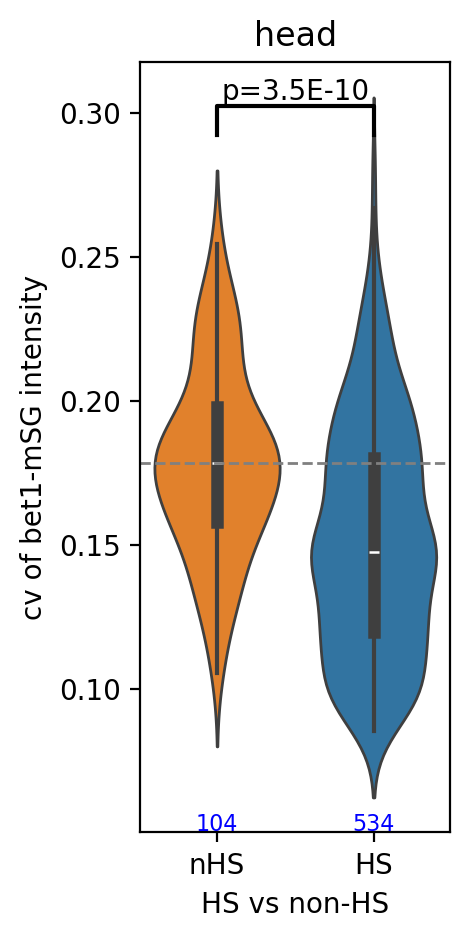

In [14]:
df_subset = df[(df['worm_region'] == "head")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='head') 

df_subset = df[(df['worm_region'] == "head") & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv', title='head')

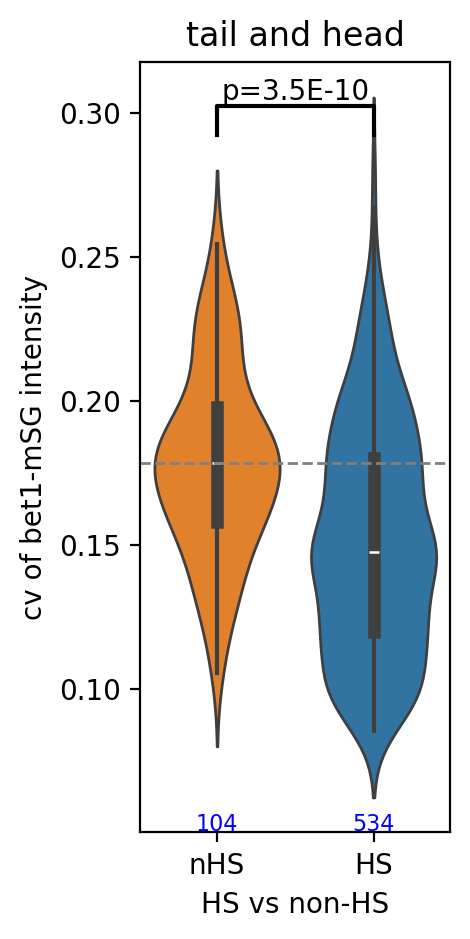

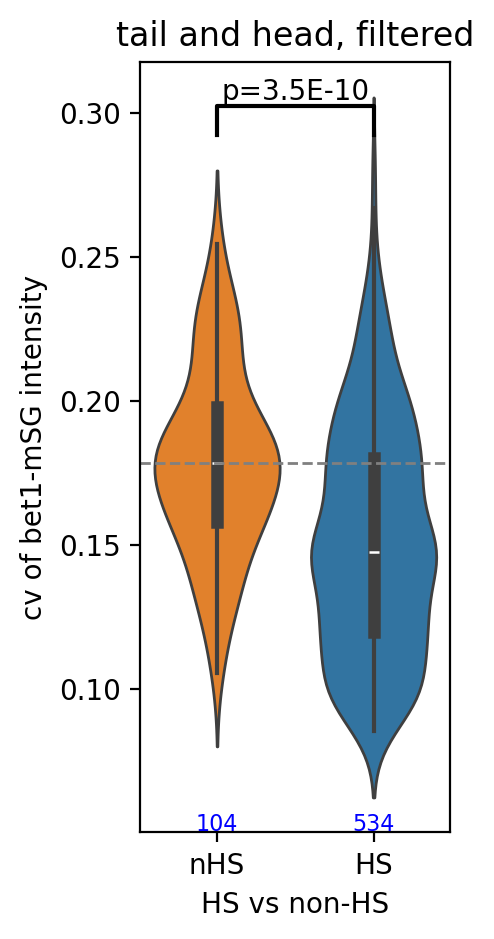

In [15]:
df_subset = df[(df['worm_region'] == "tail") | (df['worm_region'] == "head")]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail and head')

df_subset = df[((df['worm_region'] == "tail") | (df['worm_region'] == "head")) & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv', title='tail and head, filtered')

In [16]:
if(df['worm_region'].unique() == "body_vnc").any():

    df_subset = df[(df['worm_region'] == "body_vnc")]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_vnc')

    df_subset = df[(df['worm_region'] == "body_vnc") & (df['solidity'] != np.inf) ]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_vnc, filtered')

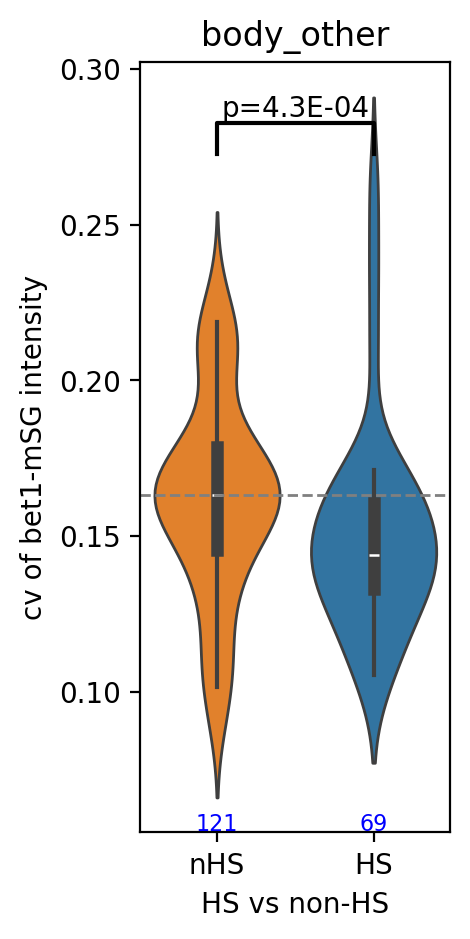

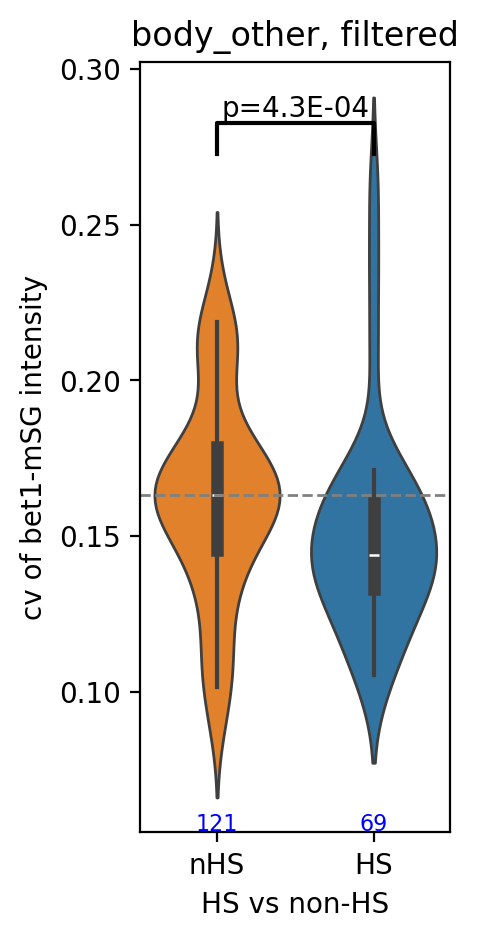

In [411]:
if(df['worm_region'].unique() == "body_other").any():

    df_subset = df[(df['worm_region'] == "body_other")]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_other')

    df_subset = df[(df['worm_region'] == "body_other") & (df['solidity'] != np.inf) ]
    plot_violin(df_subset,file_list,output_path, metric='cv', title='body_other, filtered')

## Look at individual worms to see how consistant result is


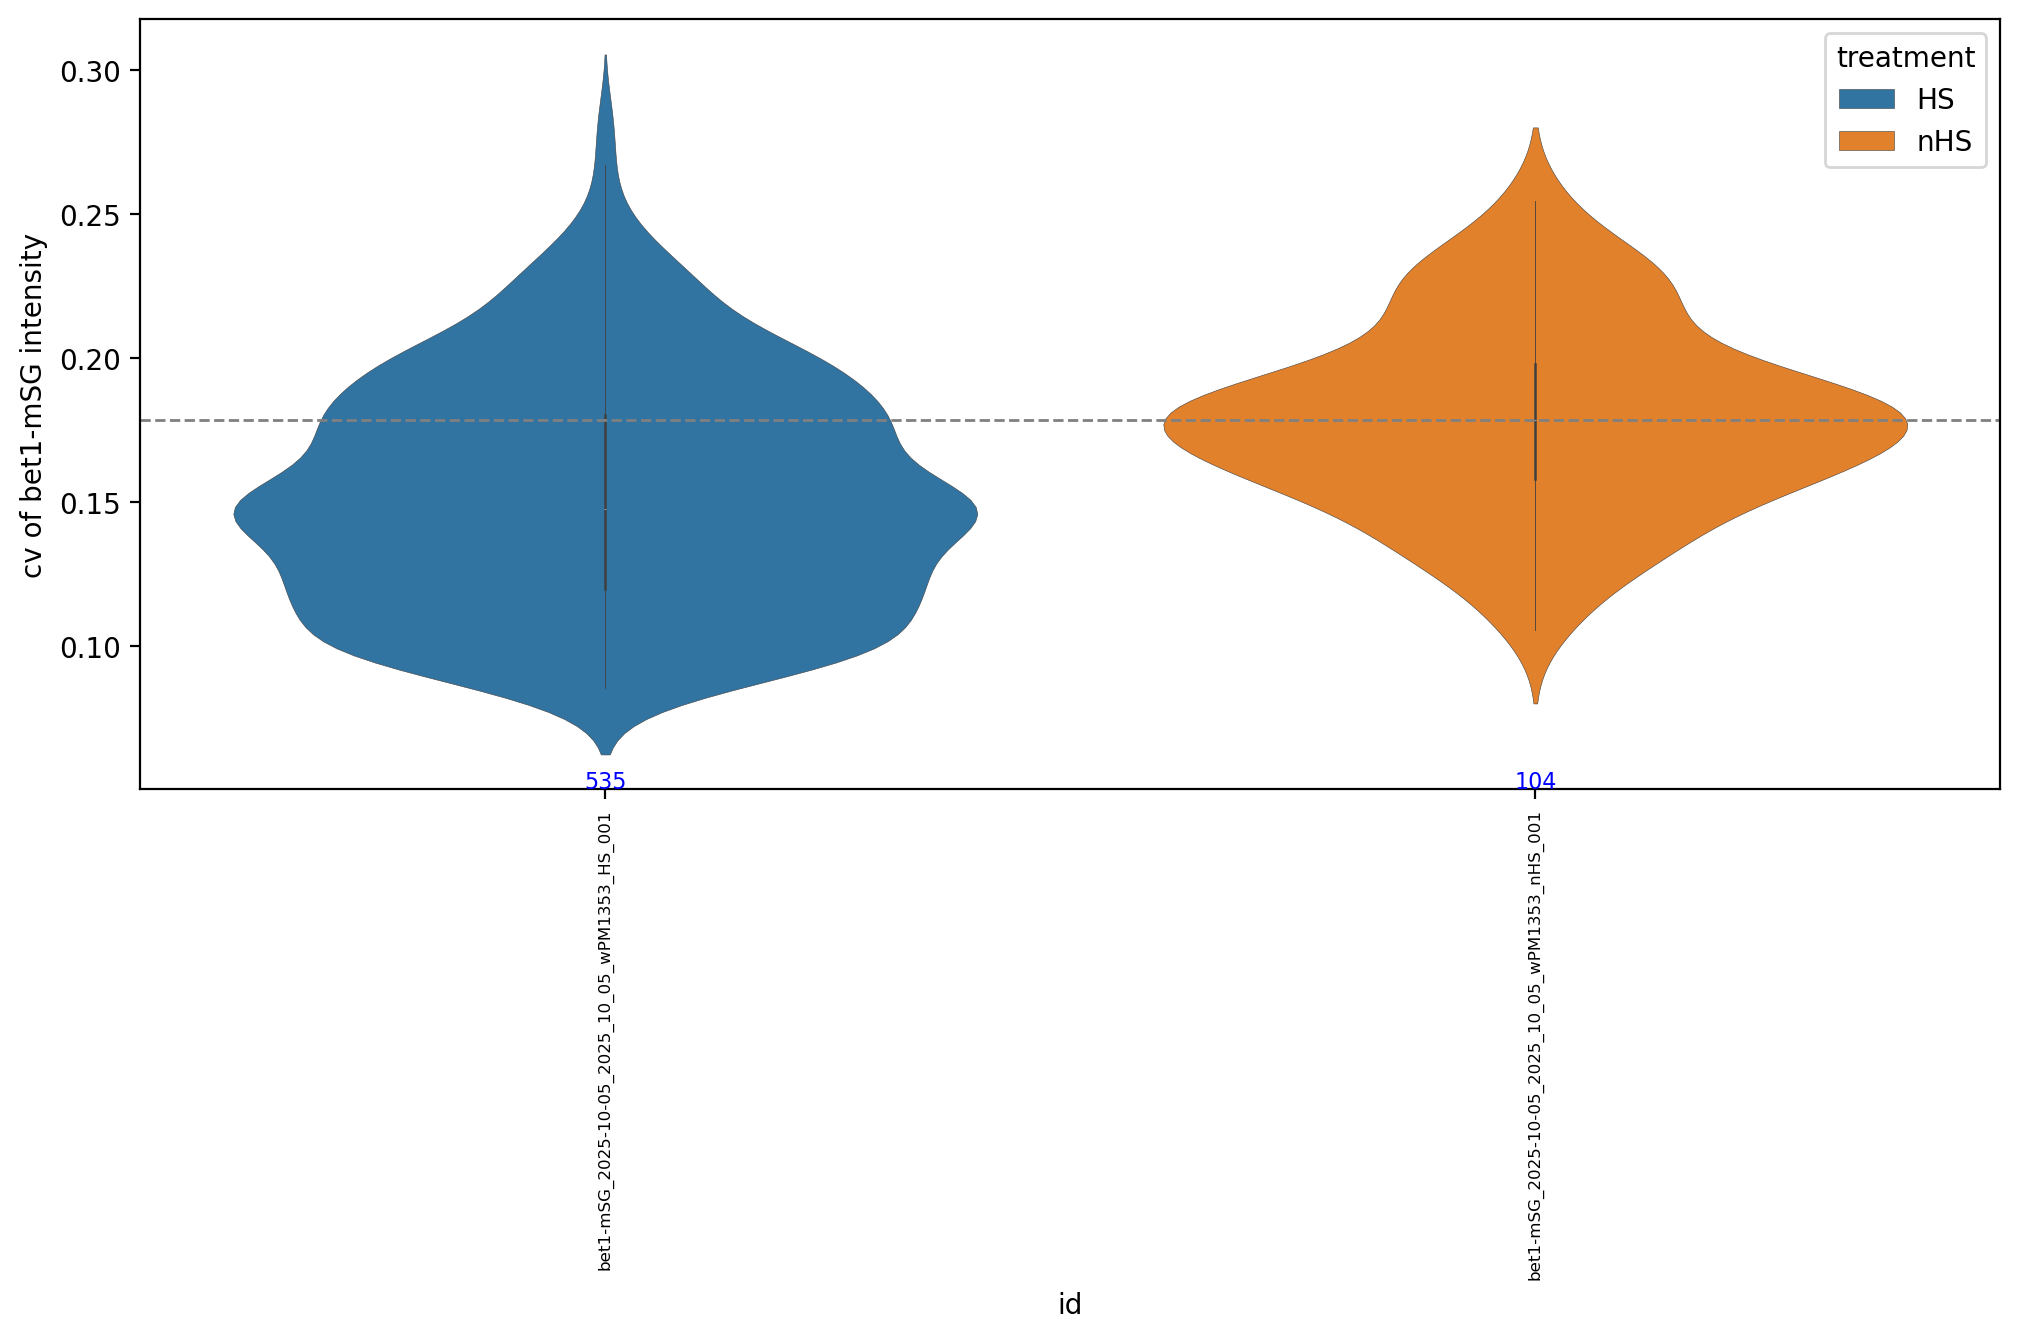

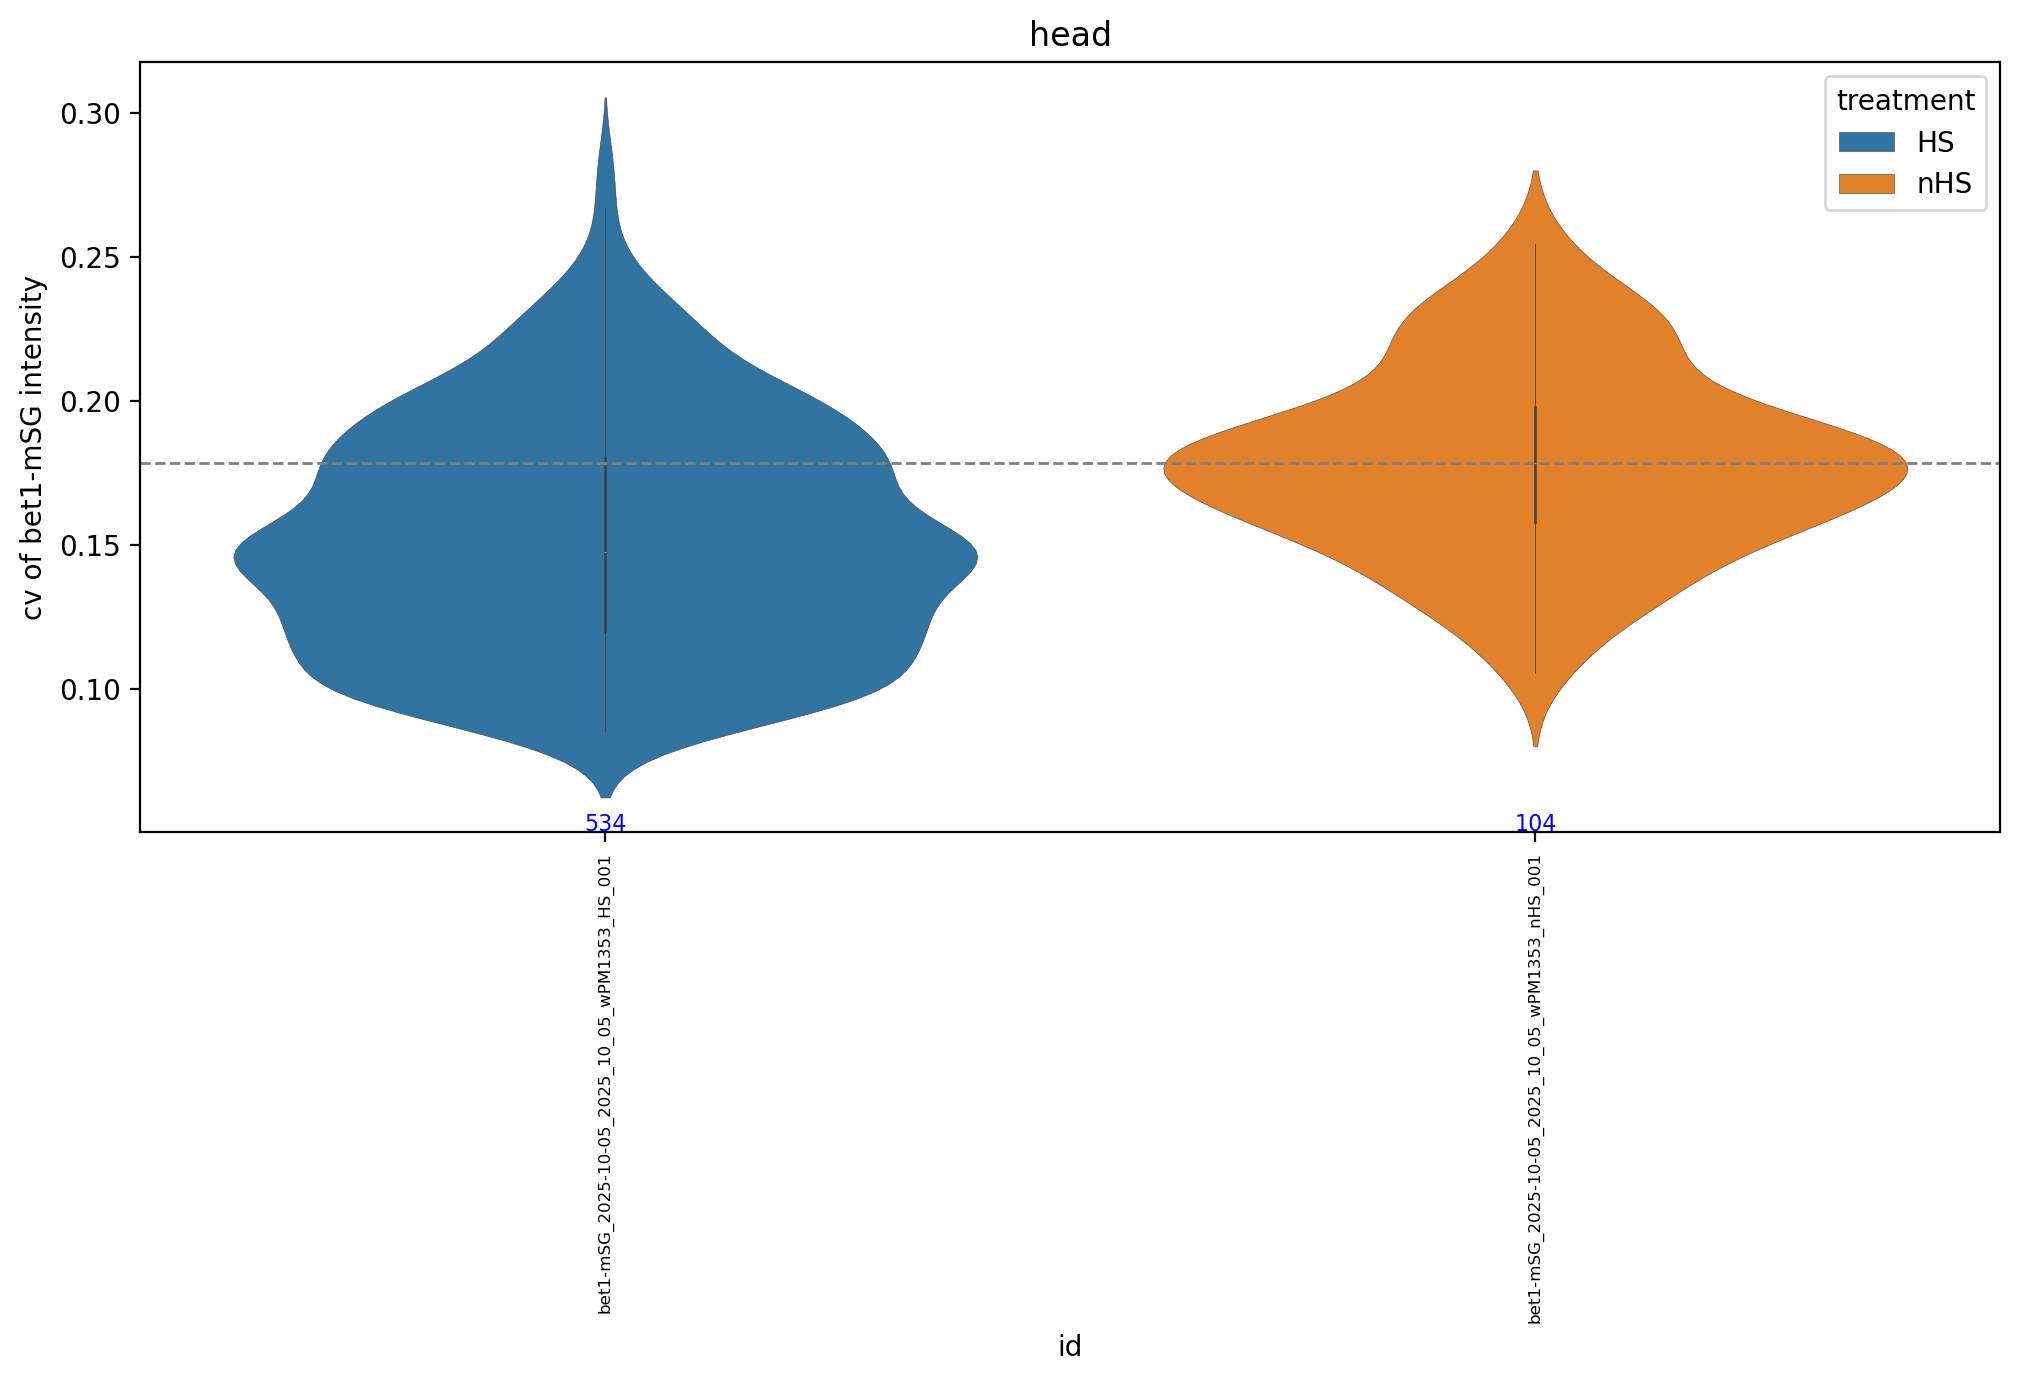

In [21]:
def plot_violin_by_worm(df,file_list,output_path, metric='cv',title=''):
    p = df.protein.unique()[0]
    plt.figure(figsize = (12,5),dpi = 200)
    order= ['nHS', 'HS']
    sns.violinplot(data=df, y=metric, x="id",hue='treatment',linewidth=0.2)

    plt.ylabel(metric+" of "+p+" intensity")
    plt.xticks(rotation=90,size=6)

    # add horizontal line for t=0
    nHS_median = df[df['treatment'] == "nHS"][metric].median()
    plt.axhline(y=nHS_median, color='grey', linestyle='--', linewidth=1)

   # get number of nuclei at each timepoint
    num_nuclei = df.groupby(['id'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]+0.01*np.abs(ylims[0])
    for n in range(len(num_nuclei)):
        plt.text(x=num_nuclei.id.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')

    plt.title(title)
    #plt.savefig(os.path.join(output_path,"plot_"+metric+"_"+str(np.where(filterNuclei, "filtNuclei", "allNuclei"))+".png"))
    plt.show()


plot_violin_by_worm(df,file_list,output_path, metric='cv')

if(df['worm_region'].unique() == "tailnuc").any():
    df_subset = df[(df['worm_region'] == "tailnuc")]
    plot_violin_by_worm(df_subset,file_list,output_path, metric='cv', title='tail tip')

if(df['worm_region'].unique() == "tail").any():
    df_subset = df[(df['worm_region'] == "tail")]
    plot_violin_by_worm(df_subset,file_list,output_path, metric='cv', title='tail all')

if(df['worm_region'].unique() == "head").any():
    df_subset = df[(df['worm_region'] == "head")]
    plot_violin_by_worm(df_subset,file_list,output_path, metric='cv', title='head')

## Functions for diagnostic plots to look at individual nuclei interactively

In [22]:
def showSegmentation(df, index):
    if nucChannel != spotChannel:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Image '+str(index)+' of '+ str(len(df)))
    im0 = axs[0].imshow(df.zproj_spots.iloc[index], cmap='gray')
    axs[0].text(0, 0, np.round(df.spot_ac_length.iloc[index],2), color='white', fontsize=12,va='top')
    plt.colorbar(im0, ax=axs[0],orientation='horizontal')

    im1 = axs[1].imshow(df.zproj_background.iloc[index], cmap='gray')
    axs[1].text(0, 0, np.round(df.bg_ac_length.iloc[index],2), color='black', fontsize=12,va='top')
    plt.colorbar(im1, ax=axs[1],orientation='horizontal')
    
    if nucChannel != spotChannel:
        im2 = axs[2].imshow(df.zproj_nuclei.iloc[index], cmap='gray')
        axs[2].text(0, 0, np.round(df.nuc_ac_length.iloc[index],2), color='white', fontsize=12,va='top')
        plt.colorbar(im2, ax=axs[1],orientation='horizontal')
    
    axs[0].set_title(df.id.iloc[index]+' t'+str(df.timepoint.iloc[index])+' lab'+str(df.label.iloc[index]))

    plt.show()
    

def selectImages(df, maxImages=10):
    chosenSet = pd.DataFrame()
    for i in range(len(df)):
        if chosenSet.shape[0] < maxImages:
            clear_output(wait=True)
            showSegmentation(df, i)
            response = input("Press Enter to continue...")
            if response=='s':
                chosenSet = pd.concat([chosenSet, df.iloc[i:(i+1)]], ignore_index=True)
                continue
            if response=='q':
                break
            else:
                continue
    return chosenSet



def showImages(df):
    for i in range(len(df)):
            clear_output(wait=True)
            showSegmentation(df, i)
            response = input("Press Enter to continue...")
            if response=='q':
                break
            else:
                continue

def exponential_decay(x, a, b,c):
    '''
    Exponenetial decay function for autocorrelation
    according to Munschi et al. 2025.
    '''                           
    return a + b * np.exp(-c * x)


def plot_acf_from_table(df, i,image_type="spot"):
    '''
    Plots the autocorrelation function for a specific row in the DataFrame
    and displays the corresponding image in a second subplot.
    '''
    img = df['zproj_spots'].iloc[i]
    #zdim=img.shape[0]
    img_mask = df['image'].iloc[i]
    autocorr = df[image_type+'_ACF'].iloc[i] #get_autocorrelation_2d(img, img_mask, maxr=12)
    fit = df[image_type+'_ac_fittedParams'].iloc[i]
    conditionNumber = df[image_type+'_ac_conditionNumber'].iloc[i]
    rmse = df[image_type+'_ac_rmse'].iloc[i]
    ac_length = df[image_type+'_ac_length'].iloc[i]
    ac_error = df[image_type+'_ac_error'].iloc[i]
    x = range(1, autocorr.size + 1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    # Plot the autocorrelation function in the first subplot
    axes[0].plot(x, autocorr, 'o', label='data')
    try:
        axes[0].plot(x, exponential_decay(x, *fit), label='fit')
    except:
        pass
    axes[0].legend()
    axes[0].set_title('Autocorrelation nucleus #'+str(i))
    axes[0].set_xlabel('Distance')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].text(0.5, 0.5, 
                 f'lambda = {ac_length:.3f} +/- {ac_error:.3f}', 
                 transform=axes[0].transAxes)
    axes[0].text(0.5, 0.6, f'fit: a={fit[0]:.3g},\nb={fit[1]:.3g},\nc={fit[2]:.3g}', 
                 transform=axes[0].transAxes)
    axes[0].text(0.5, 0.7, 'RMSE = {:.3g}'.format(rmse), transform=axes[0].transAxes)
    axes[0].text(0.5, 0.8, 'conditionNumber = {:.3g}'.format(conditionNumber), transform=axes[0].transAxes)
    # Display the image in the second subplot
    axes[1].imshow(img, cmap='gray')
    axes[1].set_title(image_type+' Channel')
    axes[1].axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

In [23]:
def plot_ac_length_histogram(dist,image_type="spot",title=""):
    percentile = dist.bg_ac_length.quantile(0.99)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    dist[image_type+'_ac_length'].hist(bins=100, ax=axs[0])
    axs[0].set_title(image_type+" all AC lengths")
    axs[0].axvline(percentile, color='red', linestyle='--', label=f'background 99th Percentile: {percentile:.2f}')
    axs[0].legend()
    axs[0].text(0.5, 0.8, f'{dist[image_type+"_ac_length"].isna().sum():.0f} NaNs out of {dist.shape[0]:.0f} total', 
                transform=axs[0].transAxes)
    axs[0].text(0.5, 0.9, f'{np.sum(dist[image_type+"_ac_length"]==0):.0f} 0s out of {dist.shape[0]:.0f} total', 
                transform=axs[0].transAxes)
    dfss = dist[(np.abs(dist[image_type+'_ac_length']) < 12)]
    dfss[image_type+'_ac_length'].hist(bins=100,ax=axs[1])
    axs[1].set_title(image_type+" abs(AC lengths) < 12 "+title)
    axs[1].set_xlim(1,12)
    axs[1].axvline(percentile, color='red', linestyle='--', label=f'background 99th Percentile: {percentile:.2f}')
    axs[1].legend()
    plt.show()

## Functions for calculating autocorrelation per worm

In [24]:
def exponential_decay(x, a, b,c):
    '''
    Exponenetial decay function for autocorrelation
    according to Munschi et al. 2025.
    '''                           
    return a + b * np.exp(-c * x) 


def fit_acf_sd(acf_mean, acf_std, num_nuclei = 1):
    '''
    Fits parameters of an exponential decay function 
    to the autocorrelation values, taking into
    account the standard deviation of the values.
    Used for multiple nuclei from single image.
    '''
    x=range(0,acf_mean.size)
    initialguess = [0.2, 0.8, 0.5]
    if(num_nuclei > 1):
        try:
            fit, covariance = optimize.curve_fit(           
                exponential_decay,                                     
                x,   
                acf_mean,     
                initialguess,
                sigma=acf_std,
                absolute_sigma=False,
                bounds=([0., 0., 0.], [1., 1., 100.]))
            rmse = np.sqrt(np.mean((acf_mean - exponential_decay(x, *fit))**2))
            conditionNumber = np.linalg.cond(covariance)  
        except RuntimeError:
            fit = [0,0,0] #[np.nan, np.nan, np.nan]
            covariance = np.zeros((3,3))
            rmse = np.nan
            conditionNumber = np.nan
    else:
        try:
            fit, covariance = optimize.curve_fit(           
                exponential_decay,                                     
                x,   
                acf_mean,    
                initialguess,
                bounds=([0., 0., 0.], [1., 1., 100.]))
            rmse = np.sqrt(np.mean((acf_mean - exponential_decay(x, *fit))**2))
            conditionNumber = np.linalg.cond(covariance) 
        except RuntimeError:
            fit = [0,0,0]#[np.nan, np.nan, np.nan]
            covariance = np.zeros((3,3))
            rmse = np.nan
            conditionNumber = np.nan
    return(fit, covariance, acf_mean, acf_std, rmse, conditionNumber)


def correlation_length(fit):
    '''
    Calculates correlation length according to
    Munschi et al. 2025.
    '''
    if np.nan not in fit:
        c=fit[2]
        x0=1
        lam=x0+np.log(2)/c
    else: 
        lam = 0 #np.nan
    return(lam)


def correlation_error(fit,cov):
    '''
    Calculates correlation length error according to
    Munschi et al. 2025.
    '''
    if np.nan not in fit:
        c=fit[2]
        sigma_c = np.sqrt(cov[2,2])
        lam = correlation_length(fit)
        lam_error = lam*sigma_c/c
    else:
        lam_error = 0 #np.nan
    return(lam_error)


def get_mean_autocorrelation_length(acf_matrix):
    '''
    Calculates autocorrelation length from matrix of ACF 
    (each row is a single nucleus ACF)
    '''
    acf_mean = acf_matrix[~np.isnan(acf_matrix[:,0]) & (acf_matrix[:,0]>0) ].mean(axis=0)
    acf_std = acf_matrix[~np.isnan(acf_matrix[:,0]) & (acf_matrix[:,0]>0) ].std(axis=0)
    num_nuclei = acf_matrix.shape[0]
    fit, cov, acf_mean, acf_std, rmse, conditionNumber = fit_acf_sd(acf_mean,acf_std,num_nuclei)
    if np.nan not in fit:
        lam = correlation_length(fit)
        lam_error = correlation_error(fit, cov)
        if(np.abs(lam)<np.abs(lam_error)):
            lam = 0#np.nan
            lam_error = 0#np.nan
    else:
        lam = 0#np.nan
        lam_error = 0#np.nan
    return(acf_mean, acf_std, lam, lam_error, fit, conditionNumber)


def plot_qc_embryo_acf(acf_matrix, id, tp, image_type="spots"):
    '''
    Plots the ACF of a single embryo.
    acf_matrix: ACF matrix of the embryo
    id: embryo ID
    tp: timepoint
    '''
    acf_mean, acf_std, lam, lam_error, spots_fit, conditionNumber = get_mean_autocorrelation_length(acf_matrix)
    n, m = acf_matrix.shape  # Get the dimensions of the array

    # Create x-coordinates (1 to 12) repeated for each row
    xx = np.tile(np.arange(1, m + 1), n)

    # Create y-coordinates (values from the array)
    yy = acf_matrix.flatten()

    # Plot the points
    plt.figure(figsize=(10, 6))
    plt.scatter(xx, yy, alpha=0.7, s=8, c='blue', label='ACF per nucleus')
    plt.title("Mean ACF of "+image_type+" per embryo "+id+" t"+str(tp))
    plt.xlabel("distance")
    plt.ylabel("autocorrelation")

    # Generate x values for the distance (1 to the length of the mean ACF)
    x = np.arange(1, len(acf_mean) + 1)

    # Calculate the fitted curve using the fit parameters
    fitted_curve = exponential_decay(x, *spots_fit)

    # Plot the mean autocorrelation function with the fitted curve
    plt.plot(x, acf_mean, 'x', label='Mean ACF', color='red')
    plt.plot(x, fitted_curve, '-', label='Fitted Curve', color='red')

    # Add a ribbon for the standard deviation
    plt.fill_between(x, acf_mean - acf_std, acf_mean + acf_std, 
                    color='red', alpha=0.2, label='Standard Deviation')
    plt.legend()

    plt.text(0.5, 0.8, f' lambda = {lam:.3f} +/- {lam_error:.3f}, {acf_matrix.shape[0]} nuclei', 
                transform=axs[0].transAxes)

    plt.show()

In [25]:
def get_mean_autocorrelation_for_plotting(dist,image_type="spot"):
    # Group by 'id' and 'timepoint' and stack the 'spot_ACF' vectors into a matrix
    grouped_acf = dist[dist[image_type+'_ac_length'].notna()].groupby(['id','treatment'])[image_type+'_ACF'].apply(
        lambda x: np.stack(x.to_numpy())
    )

    # Display the resulting grouped and stacked matrices
    grouped_acf

    ac_for_plotting = pd.DataFrame()
    for i in range(len(grouped_acf.index)):
        df_tmp =pd.DataFrame()
        id = grouped_acf.index.get_level_values(0)[i]
        tr = grouped_acf.index.get_level_values(1)[i]
        #print(f'id: {id}, timepoint: {tp}')

        ac = grouped_acf.loc[(id, tr)]
        ac = ac[ac[:, 1] > 0] # only keep rows where first ac value is >0
        ac[:,0] +=  np.random.normal(0, 0.000001, size=ac.shape[0])  # add tiny bit of noise to first point to enable fitting

        if(ac.shape[0]>0):
            acf_mean, acf_std, lam, lam_error, fit, conditionNumber = get_mean_autocorrelation_length(ac)

            df_tmp['id'] = [id]
            df_tmp['treatment'] = tr
            df_tmp[image_type+'_mean_ac_length'] = lam
            df_tmp[image_type+'_mean_ac_error'] = lam_error
            df_tmp[image_type+'_num_nuclei'] = ac.shape[0]
            ac_for_plotting = pd.concat([ac_for_plotting, df_tmp]) 

    ac_for_plotting.reset_index(drop=True, inplace=True)
    return ac_for_plotting





def plot_acf_per_worm(ac_for_plotting, image_type="spot",title=""):
    ac_for_plotting = ac_for_plotting.dropna()
    plt.figure(figsize=(10, 6))
    #plt.ylim(0, 10)
    scatter = sns.scatterplot(data=ac_for_plotting, x='id', y=image_type+'_mean_ac_length', hue='treatment',
                            palette='tab10', alpha=0.8)    
    plt.xticks(rotation=90, size=6)
    # Get the colors assigned to each 'id' from the scatter plot
    palette = scatter.legend_.legend_handles
    id_to_color = {label.get_text(): handle.get_color() for label, handle in zip(scatter.legend_.texts, palette)}


    for _, row in ac_for_plotting.iterrows():
        plt.errorbar(
            x=row['id'],
            y=row[image_type+'_mean_ac_length'],
            yerr=row[image_type+'_mean_ac_error'],
            fmt='o',
            color=id_to_color[row['treatment']],
            alpha=0.8,
            capsize=3)

    # get number of nuclei at each timepoint
    # num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]#+0.1*np.abs(ylims[0])
    id_to_index = {id_value: index for index, id_value in enumerate(ac_for_plotting['id'].unique())}

    for n, row in ac_for_plotting.iterrows():
        plt.text(x=row.id, y=ypos*1.01, s=row[image_type+'_num_nuclei'],  fontsize=8, ha='center',color=id_to_color[row['treatment']],rotation=90)   

    plt.title(title)
    



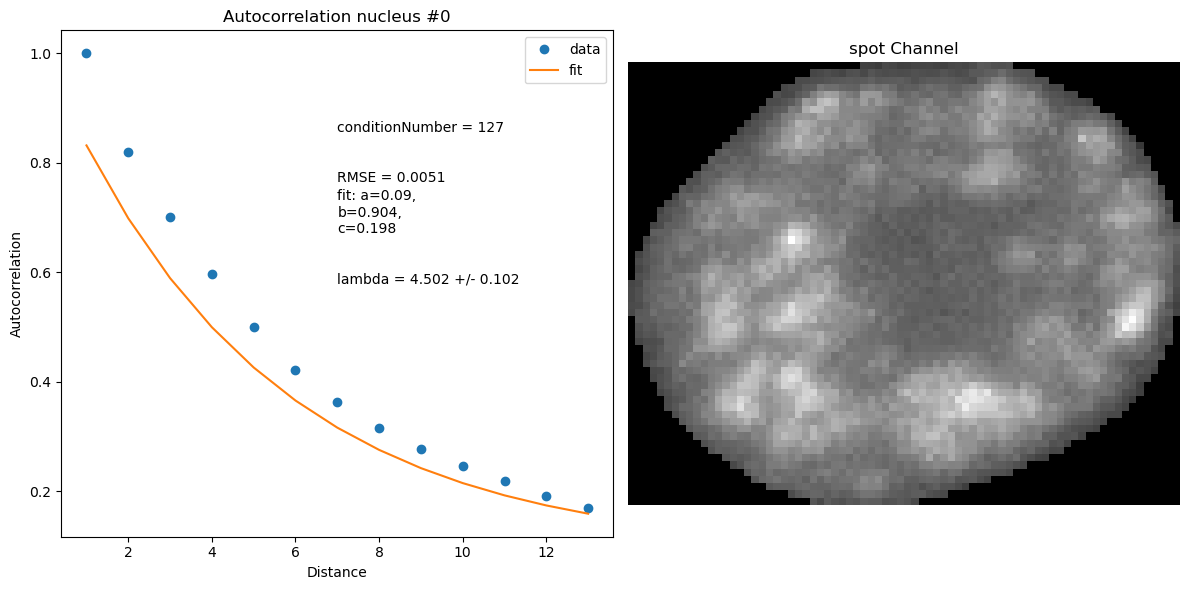

In [26]:
plot_acf_from_table(dist, 0,image_type="spot")

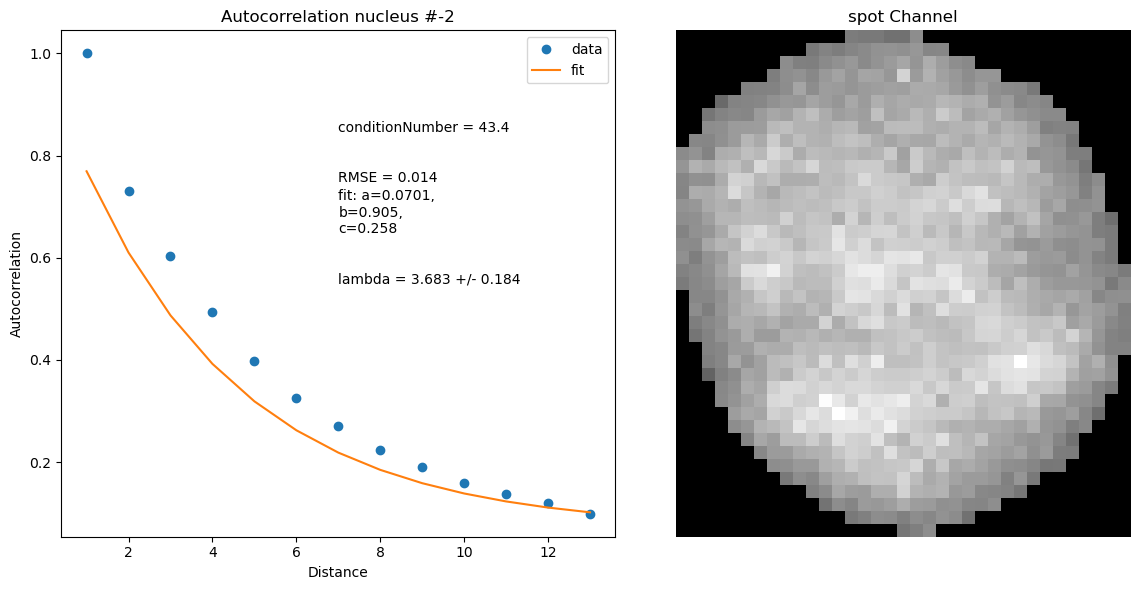

In [419]:
plot_acf_from_table(dist, -2,image_type="spot")

## Functions for plotting autocorrelation per treatment

In [27]:
def get_mean_autocorrelation_for_plotting_1var(dist,image_type="spot"):
    # Group by 'id' and 'timepoint' and stack the 'spot_ACF' vectors into a matrix
    grouped_acf = dist[dist[image_type+'_ac_length'].notna()].groupby(['treatment'])[image_type+'_ACF'].apply(
        lambda x: np.stack(x.to_numpy())
    )

    # Display the resulting grouped and stacked matrices
    grouped_acf

    ac_for_plotting = pd.DataFrame()
    for i in range(len(grouped_acf.index)):
        df_tmp =pd.DataFrame()
        tr = grouped_acf.index.get_level_values(0)[i]
        #print(f'id: {id}, timepoint: {tp}')

        ac = grouped_acf.loc[(tr)]
        #ac = ac[ac[:, 1] > 0] # only keep rows where first ac value is >0
        ac[:,0] +=  np.random.normal(0, 0.0001, size=ac.shape[0])  # add tiny bit of noise to first point to enable fitting

        if(ac.shape[0]>0):
            acf_mean, acf_std, lam, lam_error, fit, conditionNumber = get_mean_autocorrelation_length(ac)

            df_tmp['treatment'] = [tr]
            df_tmp[image_type+'_mean_ac_length'] = lam
            df_tmp[image_type+'_mean_ac_error'] = lam_error
            df_tmp[image_type+'_num_nuclei'] = ac.shape[0]
            ac_for_plotting = pd.concat([ac_for_plotting, df_tmp]) 

    ac_for_plotting.reset_index(drop=True, inplace=True)
    return ac_for_plotting


def plot_acf_per_treatment(ac_for_plotting, image_type="spot"):
    ac_for_plotting = ac_for_plotting.dropna()
    plt.figure(figsize=(2, 5))
    #plt.ylim(0, 10)
    scatter = sns.scatterplot(data=ac_for_plotting, x='treatment', y=image_type+'_mean_ac_length',     
                               hue='treatment', palette='tab10', alpha=0.8)    
    plt.xticks(rotation=90, size=6)
    # Get the colors assigned to each 'id' from the scatter plot
    palette = scatter.legend_.legend_handles
    id_to_color = {label.get_text(): handle.get_color() for label, handle in zip(scatter.legend_.texts, palette)}


    for _, row in ac_for_plotting.iterrows():
        plt.errorbar(
            x=row['treatment'],
            y=row[image_type+'_mean_ac_length'],
            yerr=row[image_type+'_mean_ac_error'],
            fmt='o',
            color=id_to_color[row['treatment']],
            alpha=0.8,
            capsize=3)

    # get number of nuclei at each timepoint
    # num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]#+0.1*np.abs(ylims[0])
    id_to_index = {id_value: index for index, id_value in enumerate(ac_for_plotting['treatment'].unique())}

    for n, row in ac_for_plotting.iterrows():
        plt.text(x=row.treatment, y=ypos*1.001, s=row[image_type+'_num_nuclei'],  fontsize=8, ha='center',color=id_to_color[row['treatment']],rotation=0)  

In [28]:
def get_acf_curves(dist,image_type="spot"):
    # Group by 'id' and 'timepoint' and stack the 'spot_ACF' vectors into a matrix
    grouped_acf = dist[dist[image_type+'_ac_length'].notna()].groupby(['treatment'])[image_type+'_ACF'].apply(
        lambda x: np.stack(x.to_numpy())
    )

    # Display the resulting grouped and stacked matrices
    grouped_acf

    ac_for_plotting = pd.DataFrame()
    for i in range(len(grouped_acf.index)):
        df_tmp =pd.DataFrame()
        tr = grouped_acf.index.get_level_values(0)[i]
        #print(f'id: {id}, timepoint: {tp}')

        ac = grouped_acf.loc[(tr)]
        ac = ac[ac[:, 1] > 0] # only keep rows where first ac value is >0
        ac[:,0] +=  np.random.normal(0, 0.0001, size=ac.shape[0])  # add tiny bit of noise to first point to enable fitting

        if(ac.shape[0]>0):
            acf_mean, acf_std, lam, lam_error, fit, conditionNumber = get_mean_autocorrelation_length(ac)

            df_tmp['image_type'] = [image_type]
            df_tmp['treatment'] = [tr]
            df_tmp['mean_ac_length'] = lam
            df_tmp['mean_ac_error'] = lam_error
            df_tmp['num_nuclei'] = ac.shape[0]
            df_tmp['ACF'] = [acf_mean]
            df_tmp['ACF_std'] = [acf_std]
            df_tmp['ACF_fit'] = [fit]
            ac_for_plotting = pd.concat([ac_for_plotting, df_tmp]) 

    ac_for_plotting.reset_index(drop=True, inplace=True)
    return ac_for_plotting




In [29]:
def plot_ac_length_barplot(dist, title=""):
    spotCurves = get_acf_curves(dist,image_type="spot") 
    bgCurves = get_acf_curves(dist,image_type="bg") 

    curves = pd.concat([bgCurves, spotCurves], ignore_index=True)
    curves.reset_index(drop=True, inplace=True)
    curves['mean_ac_length_nm'] = curves['mean_ac_length']*dist.pixelSize.iloc[0]*1000
    curves['mean_ac_error_nm'] = curves['mean_ac_error']*dist.pixelSize.iloc[0]*1000

    curves=curves.sort_values(by=['treatment'],ascending=False).sort_values(by=['image_type'],ascending=True).reset_index(drop=True)

    fig,ax = plt.subplots(figsize=(5, 8))
    x=np.arange(2)
    bar_width=0.3
    b1 = ax.bar(x, curves.mean_ac_length_nm[curves.treatment=="nHS"], 
                yerr=curves.mean_ac_error_nm[curves.treatment=="nHS"], capsize=5,
            width=bar_width, label='nHS')

    b2 = ax.bar(x+bar_width, curves.mean_ac_length_nm[curves.treatment=="HS"], 
                yerr=curves.mean_ac_error_nm[curves.treatment=="HS"], capsize=5,
            width=bar_width, label='HS')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(['Background', 'emr-1::mSG'])
    ax.set_ylabel('Autocorrelation length (nm)')
    ax.legend()
    ax.set_title(title)



## plot autocorrelation


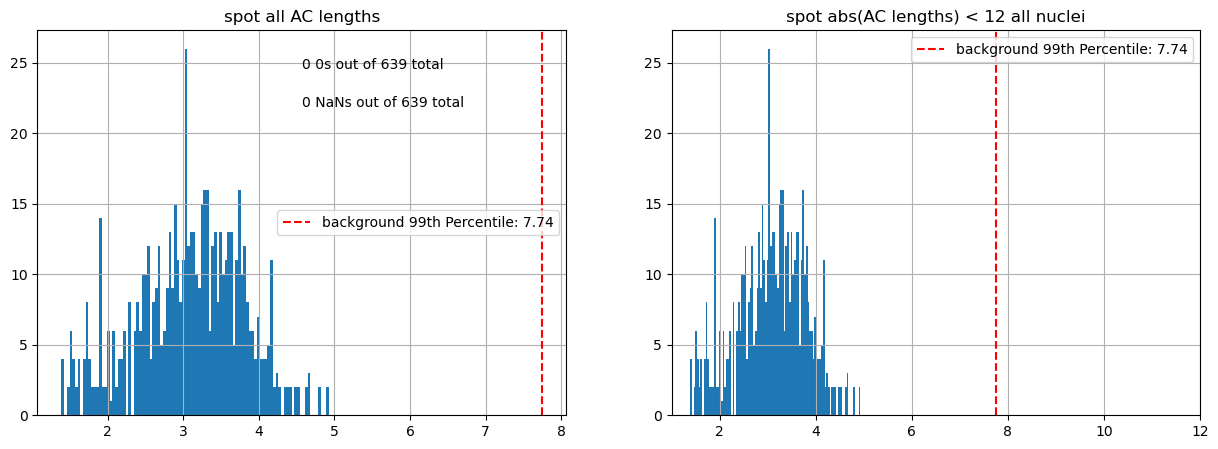

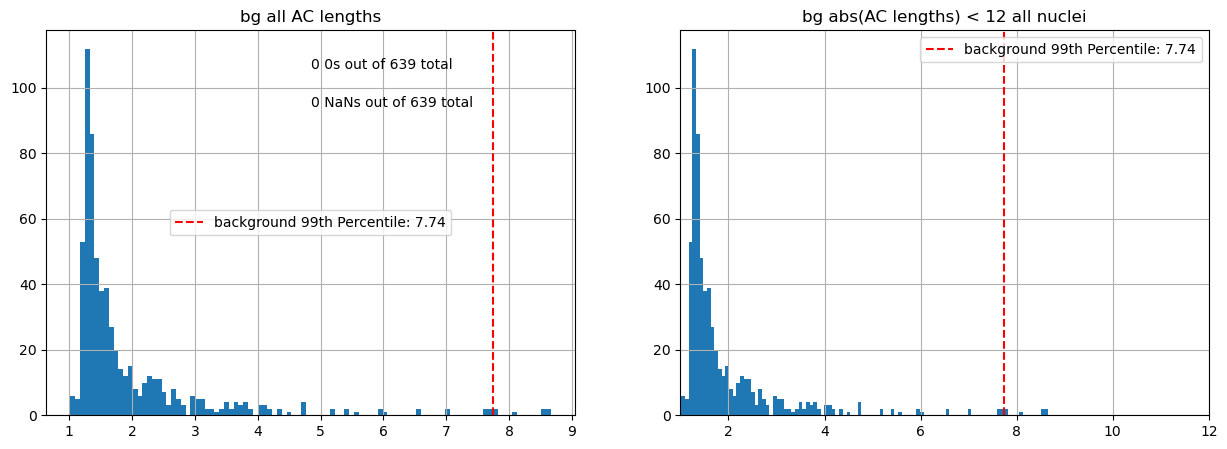

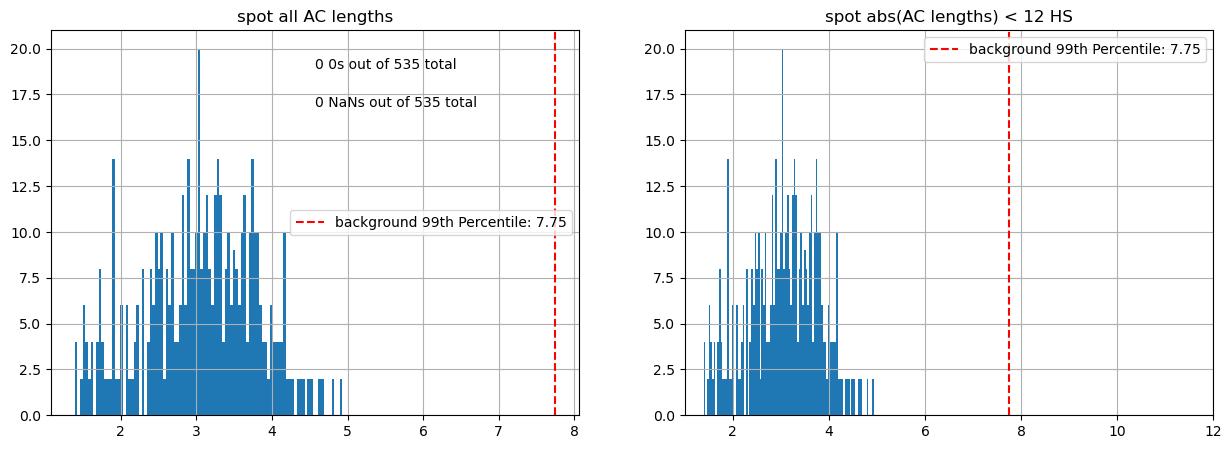

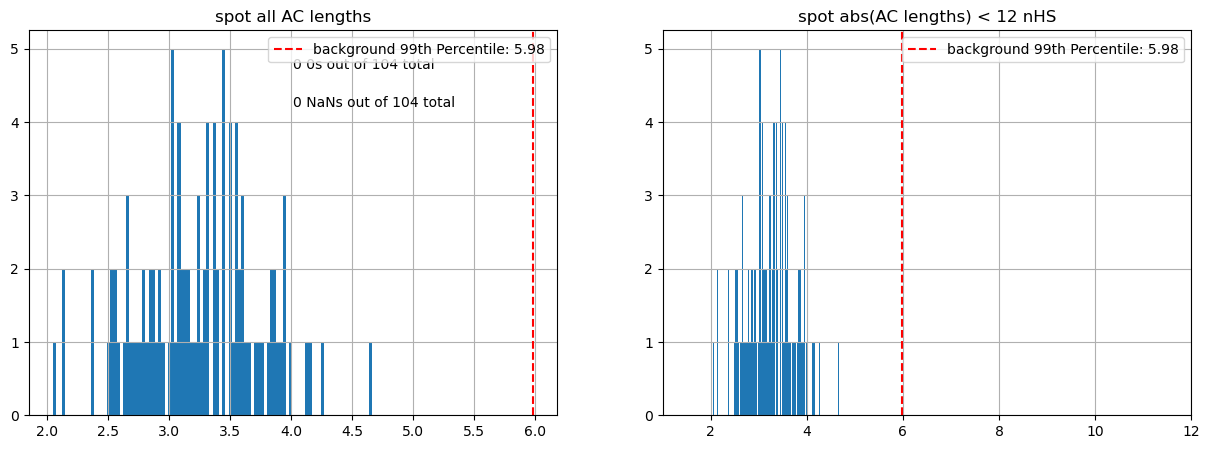

In [30]:

dist_subset=dist[(dist['worm_region'] != 'tailnuc')]

plot_ac_length_histogram(dist_subset, image_type="spot",title="all nuclei")

plot_ac_length_histogram(dist_subset, image_type="bg",title="all nuclei")


plot_ac_length_histogram(dist_subset[dist_subset.treatment=="HS"], image_type="spot", title="HS")

plot_ac_length_histogram(dist_subset[dist_subset.treatment=="nHS"], image_type="spot", title="nHS")


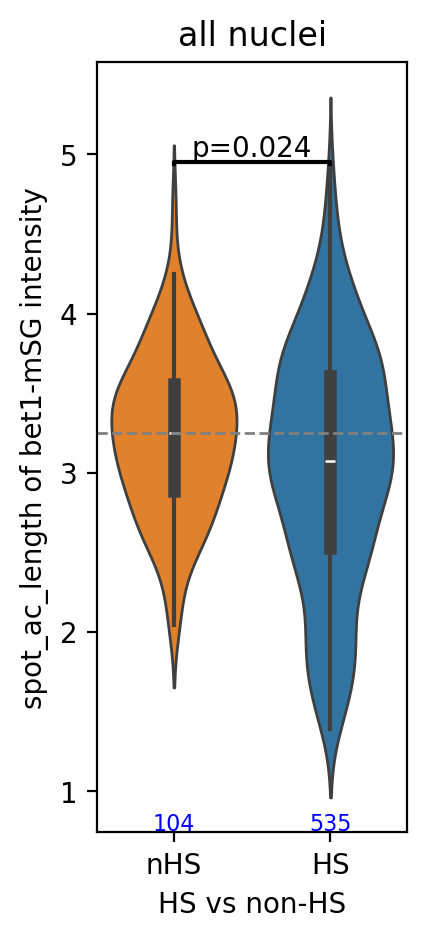

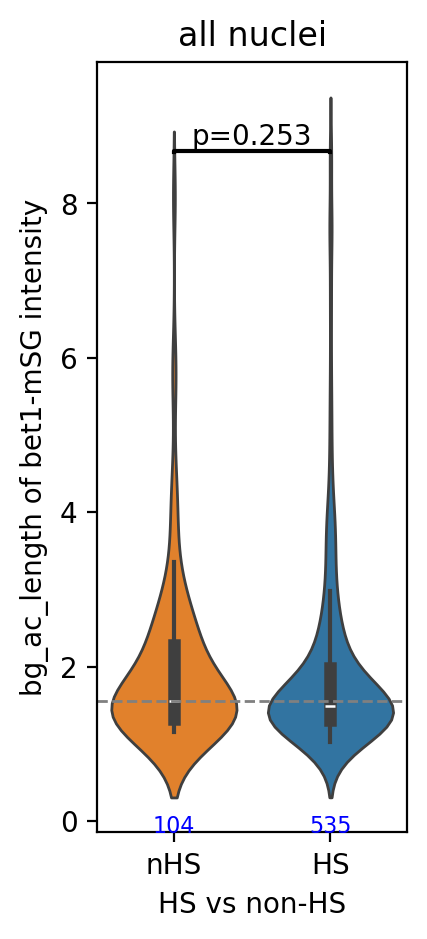

In [31]:
df_subset = df[(df['worm_region'] != "tailnuc")]
plot_violin(df_subset,file_list,output_path, metric='spot_ac_length', title='all nuclei')

plot_violin(df_subset,file_list,output_path, metric='bg_ac_length', title='all nuclei')

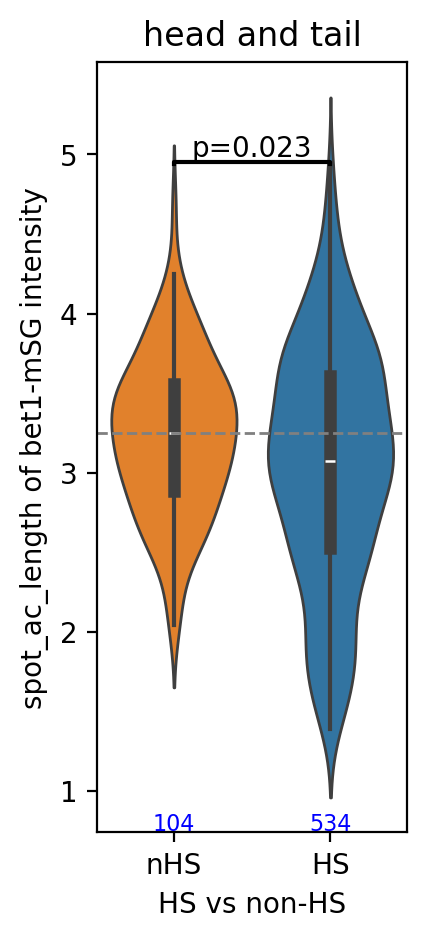

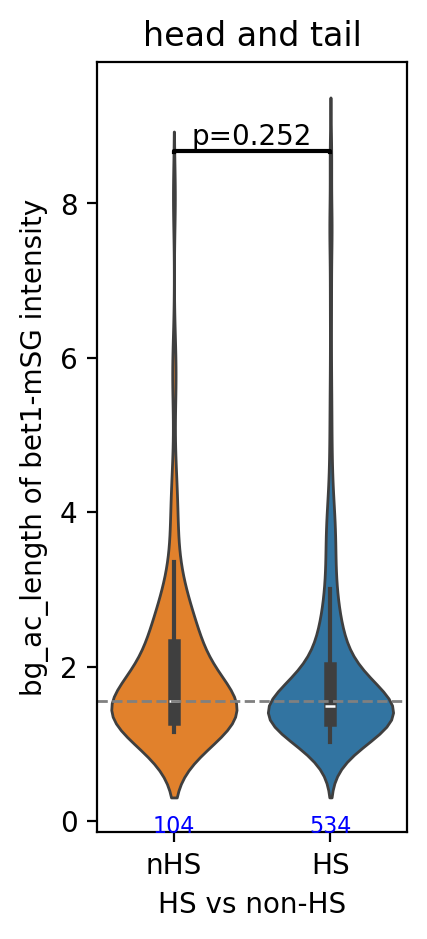

In [32]:
df_subset = df[(df['worm_region'] == "tail") | (df['worm_region'] == "head") ]
plot_violin(df_subset,file_list,output_path, metric='spot_ac_length', title='head and tail')

plot_violin(df_subset,file_list,output_path, metric='bg_ac_length', title='head and tail')

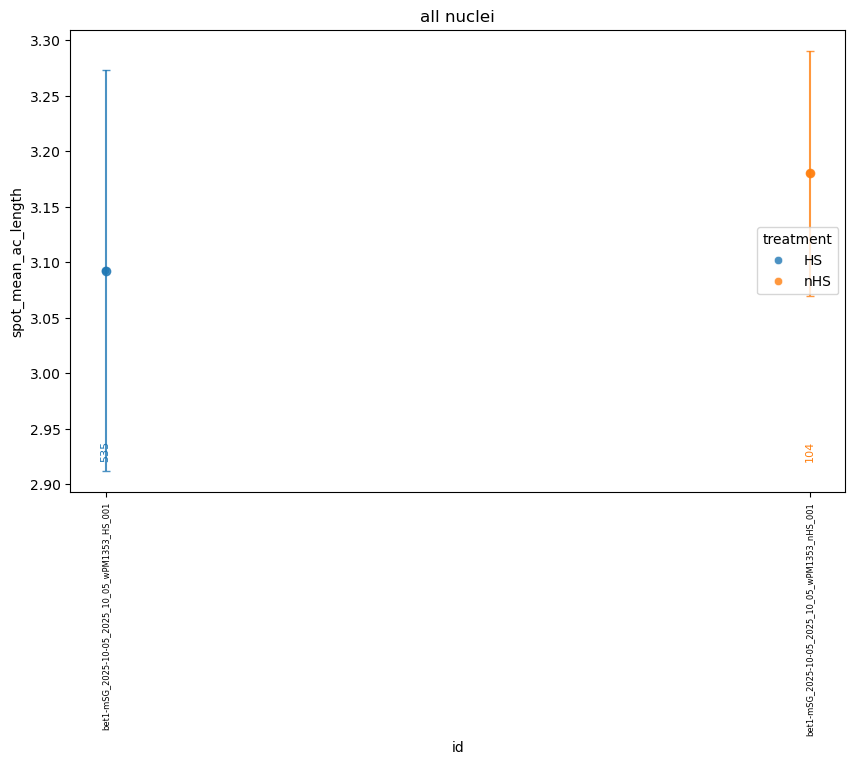

In [33]:
dist_subset = dist[(dist['worm_region'] != "tailnuc")]
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist_subset,image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='all nuclei')

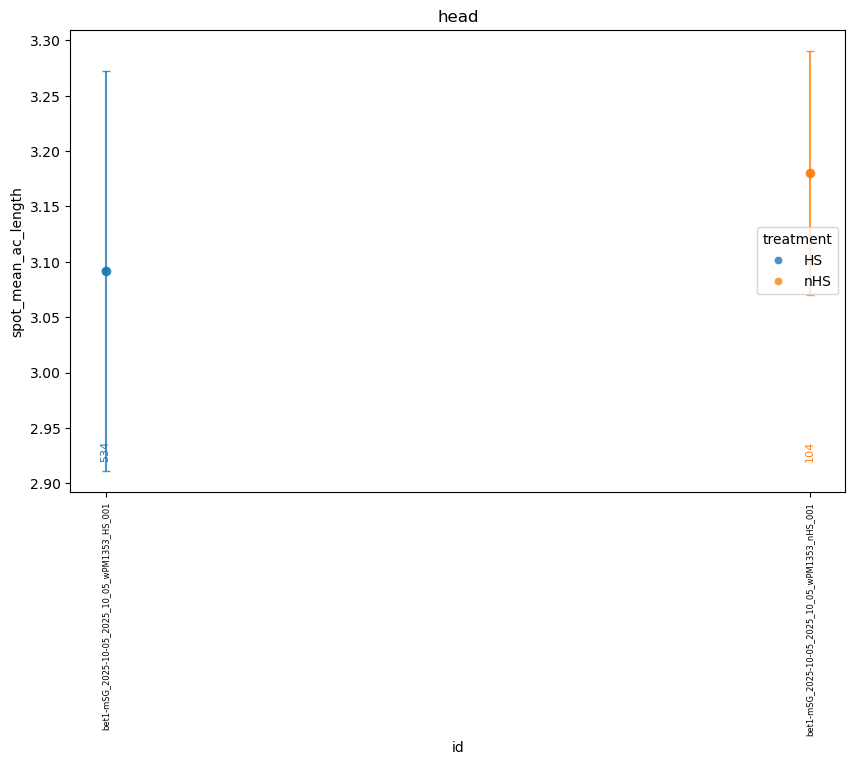

In [34]:
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist[dist.worm_region=="head"],image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='head')

In [ ]:

ac_for_plotting = get_mean_autocorrelation_for_plotting(dist[dist.worm_region=="tail"],image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='tail all')

ValueError: Could not interpret value `id` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [36]:
ac_for_plotting = get_mean_autocorrelation_for_plotting(dist[dist.worm_region=="tailnuc"],image_type="spot")

plot_acf_per_worm(ac_for_plotting, image_type="spot",title='tail tip')

ValueError: Could not interpret value `id` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

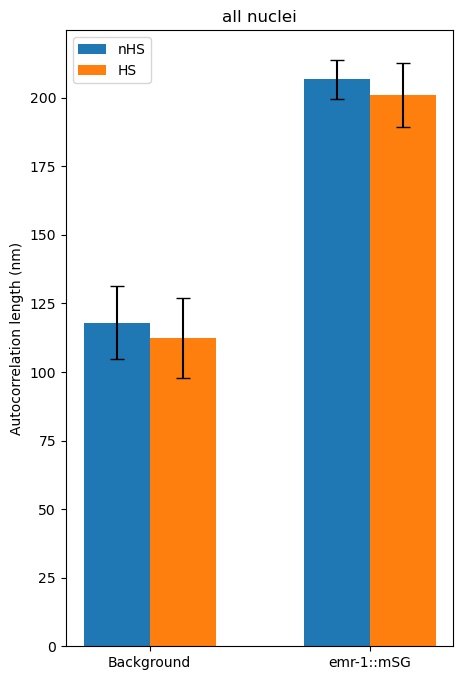

In [37]:
dist_subset = dist[(dist['worm_region'] != "tailnuc")]
plot_ac_length_barplot(dist_subset,title='all nuclei')

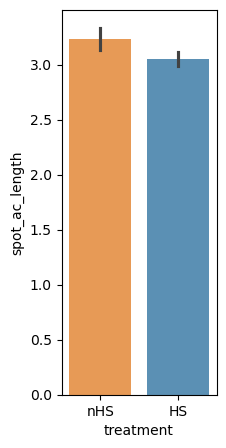

In [38]:
plt.figure(figsize=(2, 5))
#sns.barplot(data=dist[dist.worm_region=="tailnuc"], x='treatment',y='spot_ac_length',
#            hue='treatment', palette='tab10', alpha=0.8, order=['nHS', 'HS'])

ax =sns.barplot(data=dist, x='treatment',y='spot_ac_length',
            hue='treatment', palette='tab10', alpha=0.8, order=['nHS', 'HS'])
#ax.set_ylim(0,4.1)

Text(0.5, 0, 'Distance (nm)')

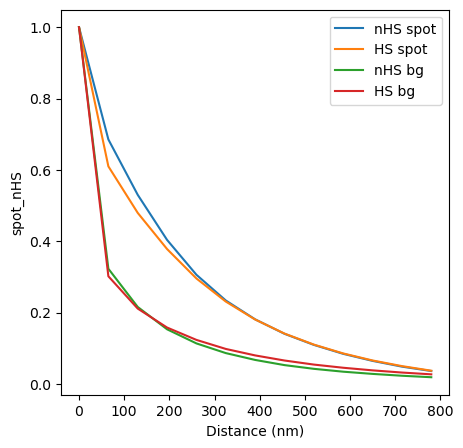

In [39]:
spotCurves = get_acf_curves(dist,image_type="spot")
bgCurves = get_acf_curves(dist,image_type="bg")

curves = pd.DataFrame({'pixels': range(0,len(spotCurves.ACF[0])),
                'spot_'+spotCurves.treatment[0]: spotCurves.ACF[0],
                'spot_'+spotCurves.treatment[1]: spotCurves.ACF[1],
                'bg_'+bgCurves.treatment[0]: bgCurves.ACF[0],
                'bg_'+bgCurves.treatment[1]: bgCurves.ACF[1]})

curves['distance'] = curves['pixels']*dist.pixelSize[0]*1000


plt.figure(figsize=(5, 5))
sns.lineplot(data=curves, x='distance', y='spot_nHS', label='nHS spot')
sns.lineplot(data=curves, x='distance', y='spot_HS', label='HS spot')
sns.lineplot(data=curves, x='distance', y='bg_nHS', label='nHS bg')
sns.lineplot(data=curves, x='distance', y='bg_HS', label='HS bg')
plt.xlabel('Distance (nm)')

In [40]:

def histogram_parameter_value(parameter_values, parameter_name):
    plt.hist(parameter_values, bins=100)
    mean_p = np.mean(parameter_values)
    median_p = np.median(parameter_values)
    plt.axvline(mean_p, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_p:.3f}')
    plt.axvline(median_p, color='blue', linestyle=':', linewidth=1, label=f'Median: {median_p:.3f}')
    plt.title('parameter: '+parameter_name)
    plt.legend()
    plt.title('paramter: '+parameter_name)
    plt.show()



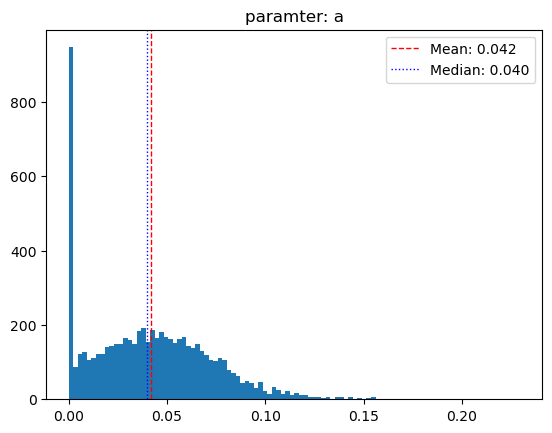

In [435]:
a=[p[0] for p in dist['spot_ac_fittedParams']]
histogram_parameter_value(a, 'a')

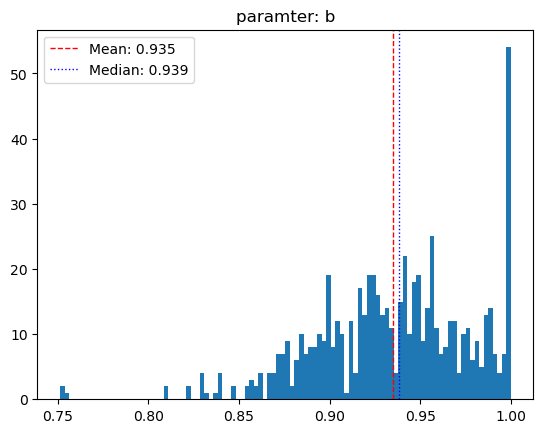

In [41]:
b=[p[1] for p in dist['spot_ac_fittedParams']]
histogram_parameter_value(b, 'b')

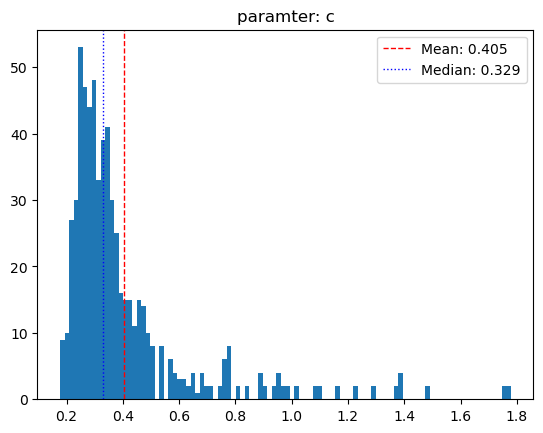

In [42]:
c=[p[2] for p in dist['spot_ac_fittedParams']]
histogram_parameter_value(c, 'c')